# Assignment 2 - Recurrent Neural Network Dynamics 

In [1]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# --- Parameters ---
m = 200
tau = 0.02
dt = 0.001
kappa = np.pi / 4
alpha = 0.9
sigma = 1
theta = np.pi
duration = 0.06
alpha_prime = 0.9
num_time_steps = int(duration / dt) + 1
phi = np.linspace(0, 2 * np.pi, m, endpoint=False)

In [12]:
# --- All Functions ---

# --- Von Mises tuning + stimulus encoding ---
def stimulus_encoding(phi_i, theta, kappa=kappa):
    return np.exp((np.cos(phi_i - theta) - 1) / (kappa**2))

def h_theta_vector(phi, theta):
    return stimulus_encoding(phi, theta)

# --- Rescale matrix by spectral abscissa ---
def rescale_matrix(W, target_alpha):
    if np.all(W == 0):
        return W
    eigvals = linalg.eigvals(W)
    max_real = np.max(np.real(eigvals))
    return W * (target_alpha / max_real) if max_real != 0 else W

def network_model(model_num, m, phi, alpha, alpha_prime):
    def V(z, kappa=np.pi/4):
        return np.exp((np.cos(z) - 1) / kappa**2)

    def rescale_matrix(W, target_alpha):
        if np.all(W == 0):
            return W
        eigvals = linalg.eigvals(W)
        max_real = np.max(np.real(eigvals))
        return W * (target_alpha / max_real) if max_real != 0 else W

    if model_num == 1:
        # Model 1: No recurrence
        W = np.zeros((m, m))
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 2:
        # Model 2: Random symmetric
        W_tilde = np.random.normal(0, 1, (m, m))
        W = rescale_matrix(W_tilde + W_tilde.T, alpha)
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 3:
        # Model 3: Symmetric ring structure
        W = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                W[i, j] = V(phi[i] - phi[j])
        W = rescale_matrix(W, alpha)
        B = np.eye(m)
        C = np.eye(m)
        n_model = m

    elif model_num == 4:
        # Model 4: Balanced ring structure (E/I split)
        W_ring = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                W_ring[i, j] = V(phi[i] - phi[j])
        W_ring = rescale_matrix(W_ring, alpha_prime)

        n_model = 2 * m
        W = np.zeros((n_model, n_model))
        W[:m, :m] = W_ring       # E→E
        W[:m, m:] = -W_ring      # I→E
        W[m:, :m] = W_ring       # E→I
        W[m:, m:] = -W_ring      # I→I

        B = np.zeros((n_model, m))
        B[:m, :] = np.eye(m)

        C = np.zeros((m, n_model))
        C[:, :m] = np.eye(m)

    elif model_num == 5:
        # Model 5: Balanced Ring with Balanced Input (push-pull)
        W_ring = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                W_ring[i, j] = V(phi[i] - phi[j])
        W_ring = rescale_matrix(W_ring, alpha_prime)

        n_model = 2 * m
        W = np.zeros((n_model, n_model))
        W[:m, :m] = W_ring
        W[:m, m:] = -W_ring
        W[m:, :m] = W_ring
        W[m:, m:] = -W_ring

        B = np.zeros((n_model, m))
        B[:m, :] = np.eye(m)
        B[m:, :] = -np.eye(m)

        C = np.zeros((m, n_model))
        C[:, :m] = np.eye(m)

    else:
        raise ValueError(f"Model {model_num} is not implemented (must be 1–5).")

    return W, B, C, n_model


# --- Simulation ---
def simulate_model(W, B, C, h_theta, tau, dt, num_time_steps):
    n_model = W.shape[0]
    r = np.zeros((n_model, num_time_steps))
    r[:, 0] = B @ h_theta
    for i in range(1, num_time_steps):
        dr = (-r[:, i-1] + W @ r[:, i-1]) * (dt / tau)
        r[:, i] = r[:, i-1] + dr
    return r

# --- Decode θ̂(t) and compute circular distance error ---
def compute_decoding_error(r, C, sigma, phi, theta, num_trials=100):
    m, T = C.shape[0], r.shape[1]
    all_errors = []
    for _ in range(num_trials):
        trial_errors = []
        for t in range(T):
            noise = sigma * np.random.randn(m)
            o_tilde = C @ r[:, t] + noise
            x = np.sum(o_tilde * np.cos(phi))
            y = np.sum(o_tilde * np.sin(phi))
            theta_hat = np.arctan2(y, x) % (2 * np.pi)
            error = np.abs(np.angle(np.exp(1j * (theta_hat - theta))))
            trial_errors.append(error)
        all_errors.append(trial_errors)
    return np.mean(all_errors, axis=0)

## Question 1

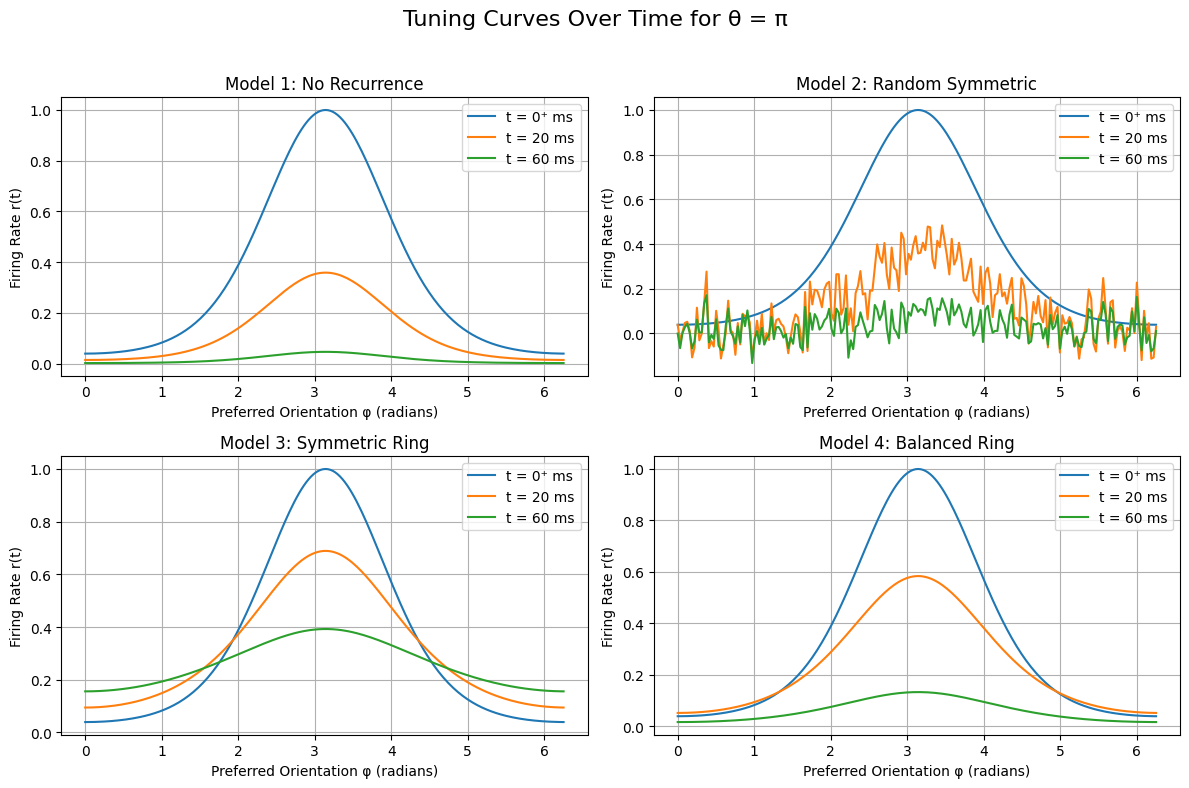

In [5]:
import matplotlib.pyplot as plt

# --- Simulation settings ---
m = 200
tau = 0.02
dt = 0.001
duration = 0.06  # 60 ms
num_time_steps = int(duration / dt) + 1
phi = np.linspace(0, 2 * np.pi, m, endpoint=False)
theta = np.pi
alpha = 0.9
alpha_prime = 0.9
time_axis = np.linspace(0, duration, num_time_steps)

# Times of interest in indices
t_0p = 0
t_20 = int(0.020 / dt)
t_60 = int(0.060 / dt)

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
titles = [
    "Model 1: No Recurrence",
    "Model 2: Random Symmetric",
    "Model 3: Symmetric Ring",
    "Model 4: Balanced Ring"
]

# Loop through all 4 models
for model_num in range(1, 5):
    # Setup model
    W, B, C, n_model = network_model(model_num, m, phi, alpha, alpha_prime)
    h_theta = h_theta_vector(phi, theta)
    r = simulate_model(W, B, C, h_theta, tau, dt, num_time_steps)

    # Extract r(t) at 0⁺, 20ms, 60ms
    r_0p = r[:m, t_0p]   # always plot only the first m neurons (excitatory)
    r_20 = r[:m, t_20]
    r_60 = r[:m, t_60]

    # Subplot position
    ax = axs[(model_num - 1) // 2][(model_num - 1) % 2]

    ax.plot(phi, r_0p, label='t = 0⁺ ms')
    ax.plot(phi, r_20, label='t = 20 ms')
    ax.plot(phi, r_60, label='t = 60 ms')
    ax.set_title(titles[model_num - 1])
    ax.set_xlabel('Preferred Orientation φ (radians)')
    ax.set_ylabel('Firing Rate r(t)')
    ax.legend()
    ax.grid(True)

# Final layout
plt.suptitle("Tuning Curves Over Time for θ = π", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Question 2

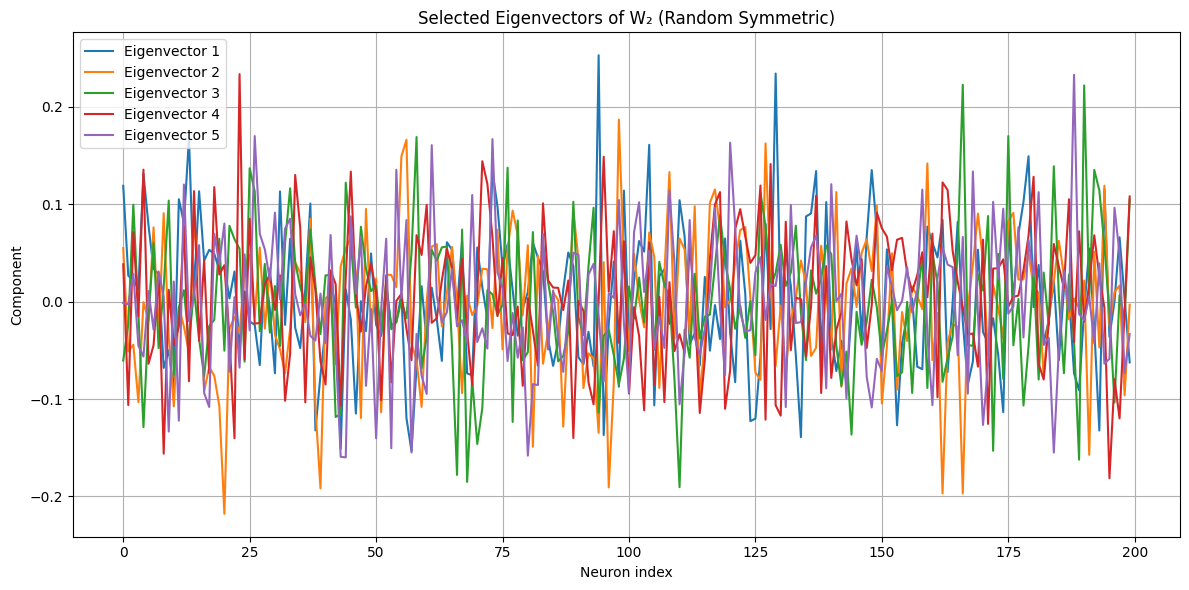

In [26]:
# --- Build W₂ matrix (random symmetric)
W2, _, _, _ = network_model(2, m, phi, alpha, alpha_prime)

# --- Eigendecomposition of W₂
eigvals_W2, eigvecs_W2 = np.linalg.eig(W2)

# --- Plot 5 sample eigenvectors
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(np.real(eigvecs_W2[:, i]), label=f"Eigenvector {i+1}")
plt.title("Selected Eigenvectors of W₂ (Random Symmetric)")
plt.xlabel("Neuron index")
plt.ylabel("Component")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 3

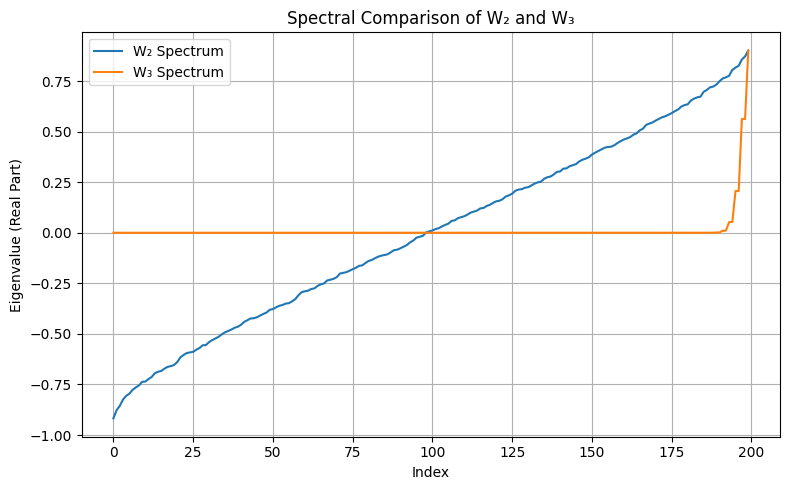

In [28]:
# --- Get eigenvalues
eigvals_2 = np.linalg.eigvals(W2)
eigvals_3 = np.linalg.eigvals(W3)

# --- Plot sorted real parts of eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(np.sort(np.real(eigvals_2)), label="W₂ Spectrum")
plt.plot(np.sort(np.real(eigvals_3)), label="W₃ Spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue (Real Part)")
plt.title("Spectral Comparison of W₂ and W₃")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


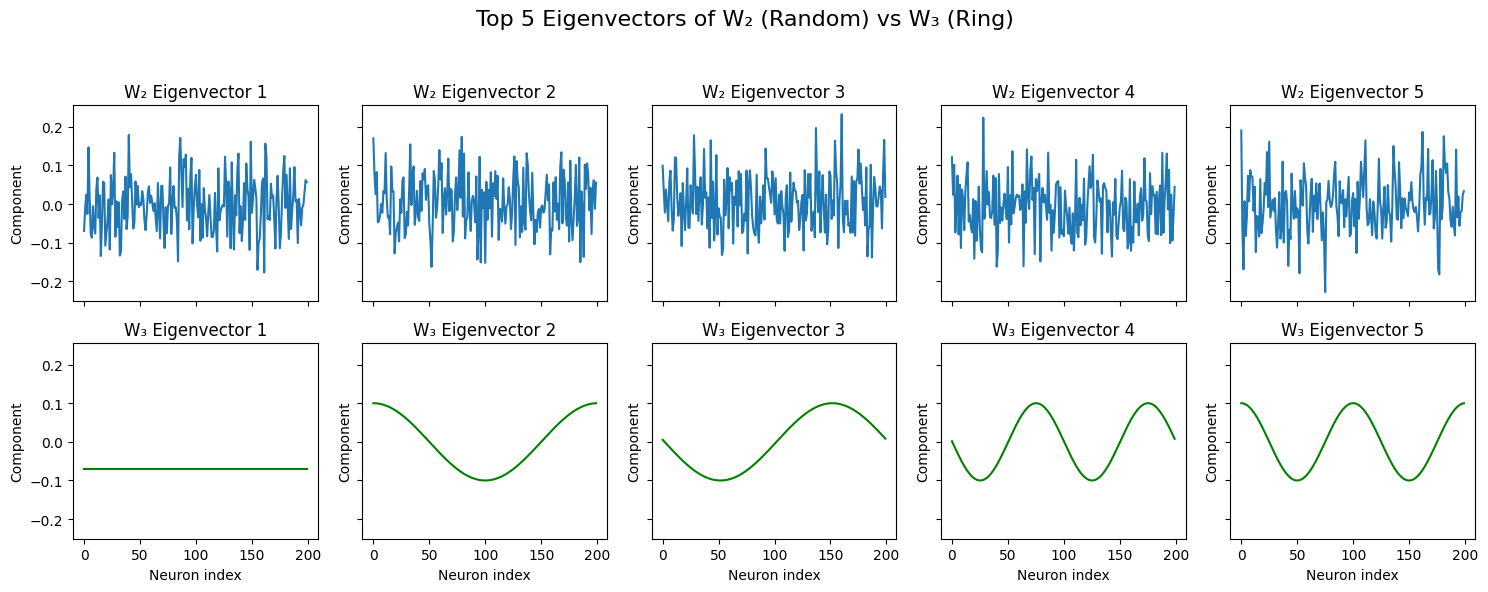

In [32]:
# --- Eigendecomposition
eigvals_W2, eigvecs_W2 = np.linalg.eig(W2)
eigvals_W3, eigvecs_W3 = np.linalg.eig(W3)

# --- Sort by descending real eigenvalue (optional: for consistent comparison)
sorted_indices_W2 = np.argsort(-np.real(eigvals_W2))
sorted_indices_W3 = np.argsort(-np.real(eigvals_W3))

# --- Plot
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)

for i in range(5):
    axs[0, i].plot(np.real(eigvecs_W2[:, sorted_indices_W2[i]]))
    axs[0, i].set_title(f"W₂ Eigenvector {i+1}")
    axs[1, i].plot(np.real(eigvecs_W3[:, sorted_indices_W3[i]]), color='green')
    axs[1, i].set_title(f"W₃ Eigenvector {i+1}")
    axs[0, i].set_ylabel("Component")
    axs[1, i].set_ylabel("Component")

for ax in axs[1]:
    ax.set_xlabel("Neuron index")

fig.suptitle("Top 5 Eigenvectors of W₂ (Random) vs W₃ (Ring)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


## Question 4

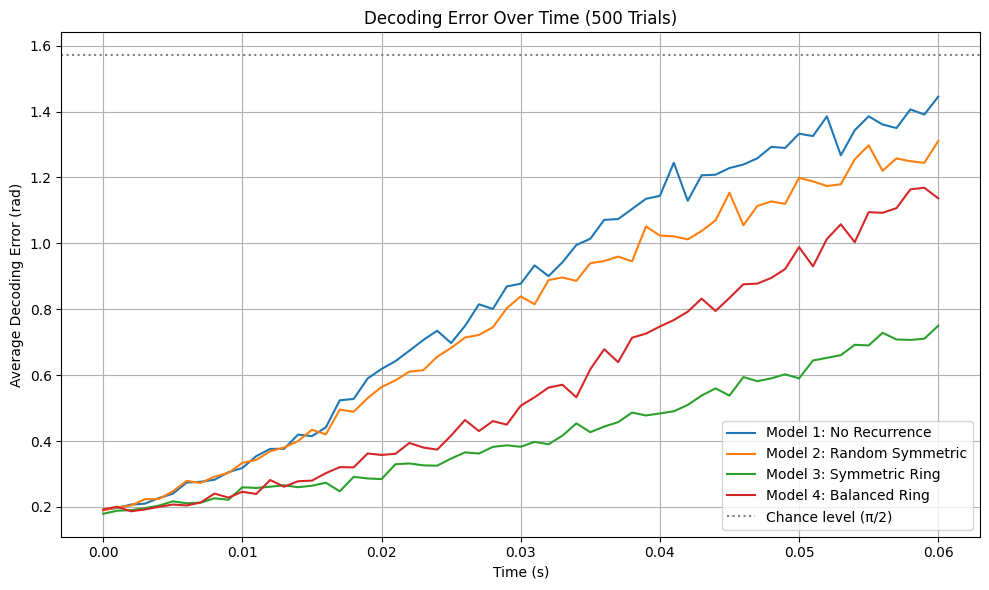

In [10]:
# --- Run everything for Model 1 and Model 2 ---
time_axis = np.linspace(0, duration, num_time_steps)
h_theta = h_theta_vector(phi, theta)

# --- Run everything for Models 1 to 4 ---
time_axis = np.linspace(0, duration, num_time_steps)
h_theta = h_theta_vector(phi, theta)

# Model 1
W1, B1, C1, _ = network_model(1, m, phi, alpha, alpha_prime)
r1 = simulate_model(W1, B1, C1, h_theta, tau, dt, num_time_steps)
error1 = compute_decoding_error(r1, C1, sigma, phi, theta, num_trials=500)

# Model 2
W2, B2, C2, _ = network_model(2, m, phi, alpha, alpha_prime)
r2 = simulate_model(W2, B2, C2, h_theta, tau, dt, num_time_steps)
error2 = compute_decoding_error(r2, C2, sigma, phi, theta, num_trials=500)

# Model 3
W3, B3, C3, _ = network_model(3, m, phi, alpha, alpha_prime)
r3 = simulate_model(W3, B3, C3, h_theta, tau, dt, num_time_steps)
error3 = compute_decoding_error(r3, C3, sigma, phi, theta, num_trials=500)

# Model 4
W4, B4, C4, _ = network_model(4, m, phi, alpha, alpha_prime)
r4 = simulate_model(W4, B4, C4, h_theta, tau, dt, num_time_steps)
error4 = compute_decoding_error(r4, C4, sigma, phi, theta, num_trials=500)

# --- Plot results ---
plt.figure(figsize=(10, 6))
plt.plot(time_axis, error1, label='Model 1: No Recurrence')
plt.plot(time_axis, error2, label='Model 2: Random Symmetric')
plt.plot(time_axis, error3, label='Model 3: Symmetric Ring')
plt.plot(time_axis, error4, label='Model 4: Balanced Ring')
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Decoding Error Over Time (500 Trials)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Question 5

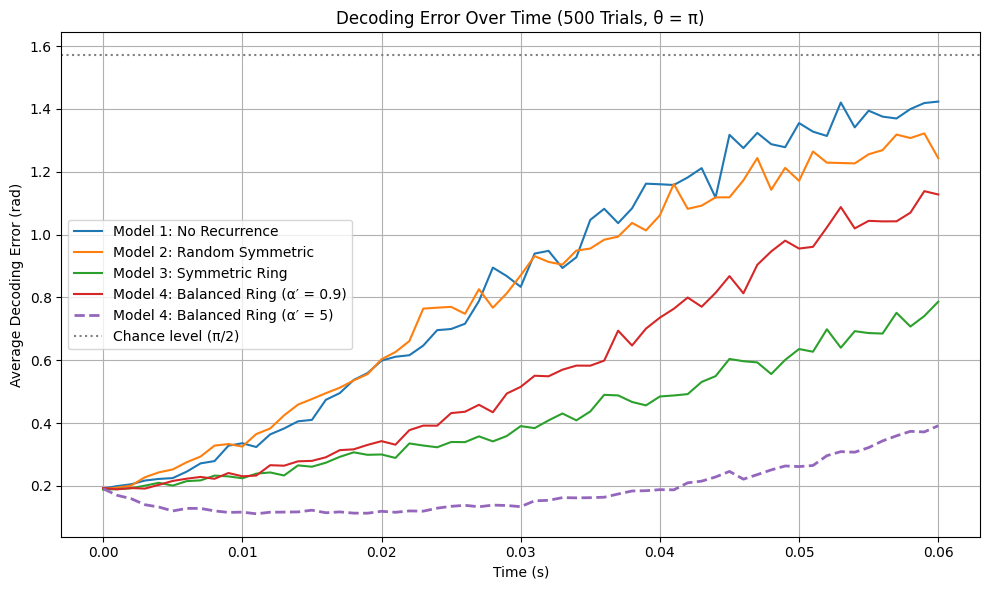

In [9]:
# --- Question 5: Compare All Models + Model 4 with α′ = 5 ---

# New alpha_prime value
alpha_prime_q5 = 5  

# Rebuild Model 4 with α′ = 5
W4_strong, B4_strong, C4_strong, _ = network_model(4, m, phi, alpha, alpha_prime_q5)
r4_strong = simulate_model(W4_strong, B4_strong, C4_strong, h_theta, tau, dt, num_time_steps)
error4_strong = compute_decoding_error(r4_strong, C4_strong, sigma, phi, theta, num_trials=500)

# --- Plot decoding error for all models including Model 4 (α′ = 5) ---
plt.figure(figsize=(10, 6))
plt.plot(time_axis, error1, label='Model 1: No Recurrence')
plt.plot(time_axis, error2, label='Model 2: Random Symmetric')
plt.plot(time_axis, error3, label='Model 3: Symmetric Ring')
plt.plot(time_axis, error4, label='Model 4: Balanced Ring (α′ = 0.9)')
plt.plot(time_axis, error4_strong, label='Model 4: Balanced Ring (α′ = 5)', linestyle='--', linewidth=2)
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Decoding Error Over Time (500 Trials, θ = π)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 6

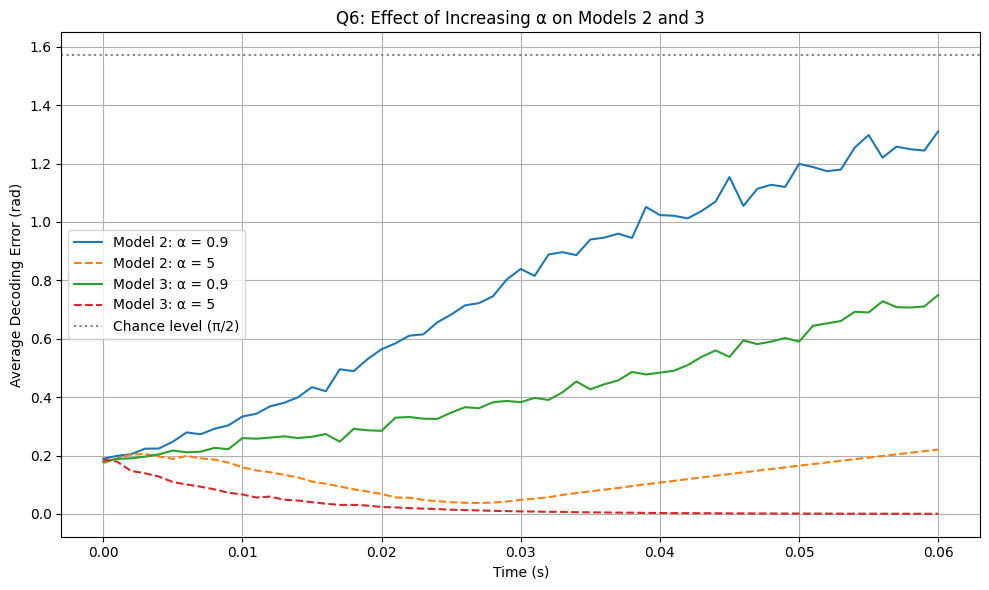

In [11]:
# --- Question 6: Models 2 and 3 with α = 5 ---
alpha_strong = 5  # New α

# --- Model 2 with α = 5 ---
W2_strong, B2_strong, C2_strong, _ = network_model(2, m, phi, alpha_strong, alpha_prime)
r2_strong = simulate_model(W2_strong, B2_strong, C2_strong, h_theta, tau, dt, num_time_steps)
error2_strong = compute_decoding_error(r2_strong, C2_strong, sigma, phi, theta, num_trials=500)

# --- Model 3 with α = 5 ---
W3_strong, B3_strong, C3_strong, _ = network_model(3, m, phi, alpha_strong, alpha_prime)
r3_strong = simulate_model(W3_strong, B3_strong, C3_strong, h_theta, tau, dt, num_time_steps)
error3_strong = compute_decoding_error(r3_strong, C3_strong, sigma, phi, theta, num_trials=500)

# --- Plot: Models 2 and 3 with α = 0.9 and α = 5 ---
plt.figure(figsize=(10, 6))
plt.plot(time_axis, error2, label='Model 2: α = 0.9')
plt.plot(time_axis, error2_strong, label='Model 2: α = 5', linestyle='--')
plt.plot(time_axis, error3, label='Model 3: α = 0.9')
plt.plot(time_axis, error3_strong, label='Model 3: α = 5', linestyle='--')
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Q6: Effect of Increasing α on Models 2 and 3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


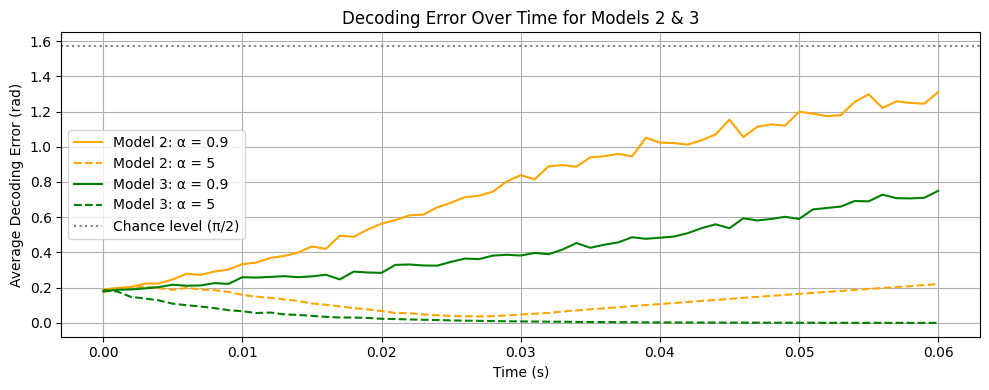

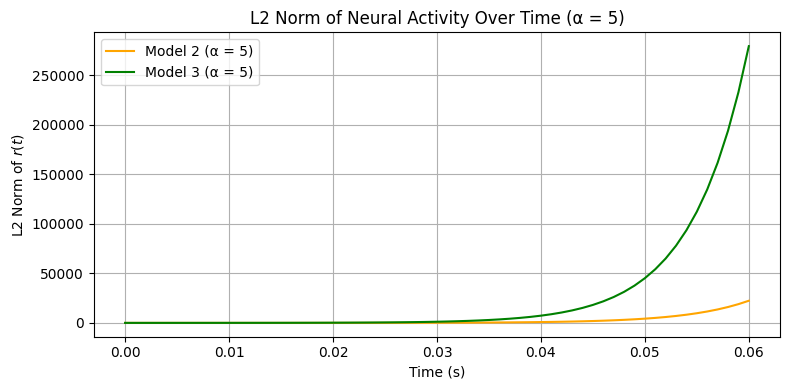

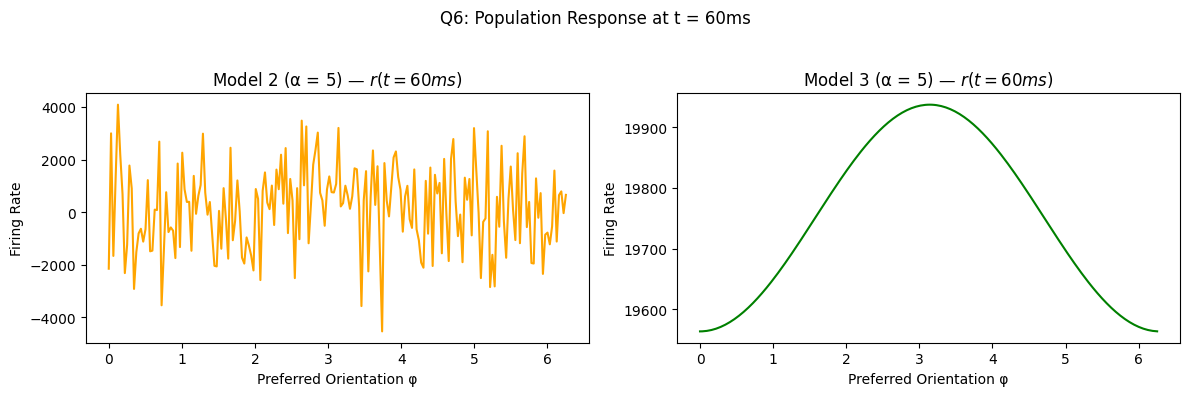

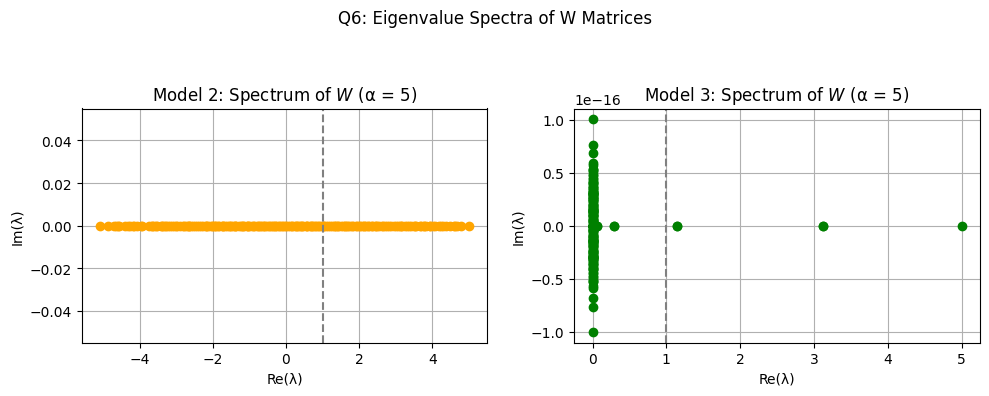

In [34]:
# --- Decoding Error Over Time (α = 0.9 vs α = 5) ---
plt.figure(figsize=(10, 4))
plt.plot(time_axis, error2, label='Model 2: α = 0.9', color='orange')
plt.plot(time_axis, error2_strong, label='Model 2: α = 5', color='orange', linestyle='--')
plt.plot(time_axis, error3, label='Model 3: α = 0.9', color='green')
plt.plot(time_axis, error3_strong, label='Model 3: α = 5', color='green', linestyle='--')
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Decoding Error Over Time for Models 2 & 3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- L2 Norm of r(t) over time for both models ---
norm_r2_strong = np.linalg.norm(r2_strong, axis=0)
norm_r3_strong = np.linalg.norm(r3_strong, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(time_axis, norm_r2_strong, label="Model 2 (α = 5)", color='orange')
plt.plot(time_axis, norm_r3_strong, label="Model 3 (α = 5)", color='green')
plt.xlabel("Time (s)")
plt.ylabel("L2 Norm of $r(t)$")
plt.title("L2 Norm of Neural Activity Over Time (α = 5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Tuning curves (population response at t = 60 ms) ---
idx_60 = int(0.06 / dt)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(phi, r2_strong[:, idx_60], color='orange')
plt.title("Model 2 (α = 5) — $r(t=60ms)$")
plt.xlabel("Preferred Orientation φ")
plt.ylabel("Firing Rate")

plt.subplot(1, 2, 2)
plt.plot(phi, r3_strong[:, idx_60], color='green')
plt.title("Model 3 (α = 5) — $r(t=60ms)$")
plt.xlabel("Preferred Orientation φ")
plt.ylabel("Firing Rate")

plt.suptitle("Q6: Population Response at t = 60ms")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Eigenvalue spectra of W matrices ---
eigvals2 = np.linalg.eigvals(W2_strong)
eigvals3 = np.linalg.eigvals(W3_strong)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.real(eigvals2), np.imag(eigvals2), 'o', label='Model 2', color='orange')
plt.axvline(x=1, color='gray', linestyle='--')
plt.title("Model 2: Spectrum of $W$ (α = 5)")
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.real(eigvals3), np.imag(eigvals3), 'o', label='Model 3', color='green')
plt.axvline(x=1, color='gray', linestyle='--')
plt.title("Model 3: Spectrum of $W$ (α = 5)")
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.grid(True)

plt.suptitle("Q6: Eigenvalue Spectra of W Matrices")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


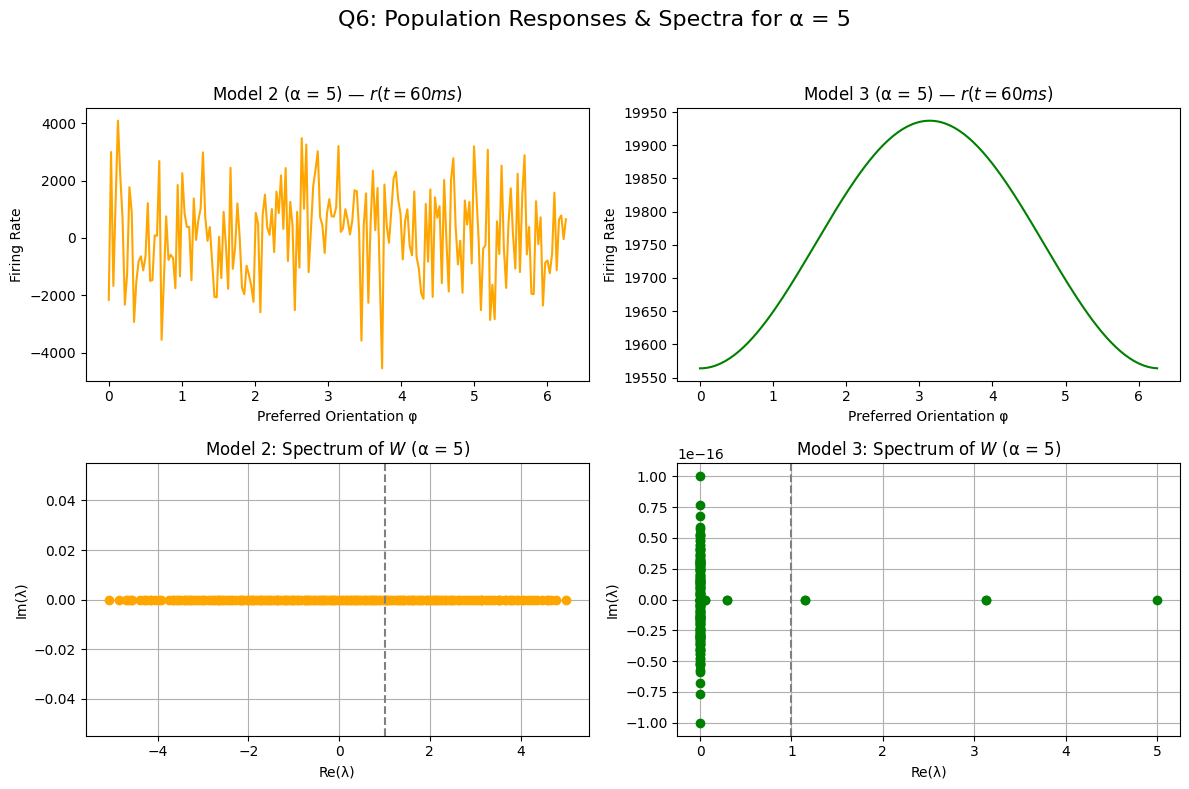

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# --- Top row: r(t=60ms) tuning curves ---
axs[0, 0].plot(phi, r2_strong[:, idx_60], color='orange')
axs[0, 0].set_title("Model 2 (α = 5) — $r(t=60ms)$")
axs[0, 0].set_xlabel("Preferred Orientation φ")
axs[0, 0].set_ylabel("Firing Rate")

axs[0, 1].plot(phi, r3_strong[:, idx_60], color='green')
axs[0, 1].set_title("Model 3 (α = 5) — $r(t=60ms)$")
axs[0, 1].set_xlabel("Preferred Orientation φ")
axs[0, 1].set_ylabel("Firing Rate")

# --- Bottom row: Eigenvalue spectra ---
axs[1, 0].plot(np.real(eigvals2), np.imag(eigvals2), 'o', color='orange')
axs[1, 0].axvline(x=1, color='gray', linestyle='--')
axs[1, 0].set_title("Model 2: Spectrum of $W$ (α = 5)")
axs[1, 0].set_xlabel("Re(λ)")
axs[1, 0].set_ylabel("Im(λ)")
axs[1, 0].grid(True)

axs[1, 1].plot(np.real(eigvals3), np.imag(eigvals3), 'o', color='green')
axs[1, 1].axvline(x=1, color='gray', linestyle='--')
axs[1, 1].set_title("Model 3: Spectrum of $W$ (α = 5)")
axs[1, 1].set_xlabel("Re(λ)")
axs[1, 1].set_ylabel("Im(λ)")
axs[1, 1].grid(True)

fig.suptitle("Q6: Population Responses & Spectra for α = 5", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Question 7

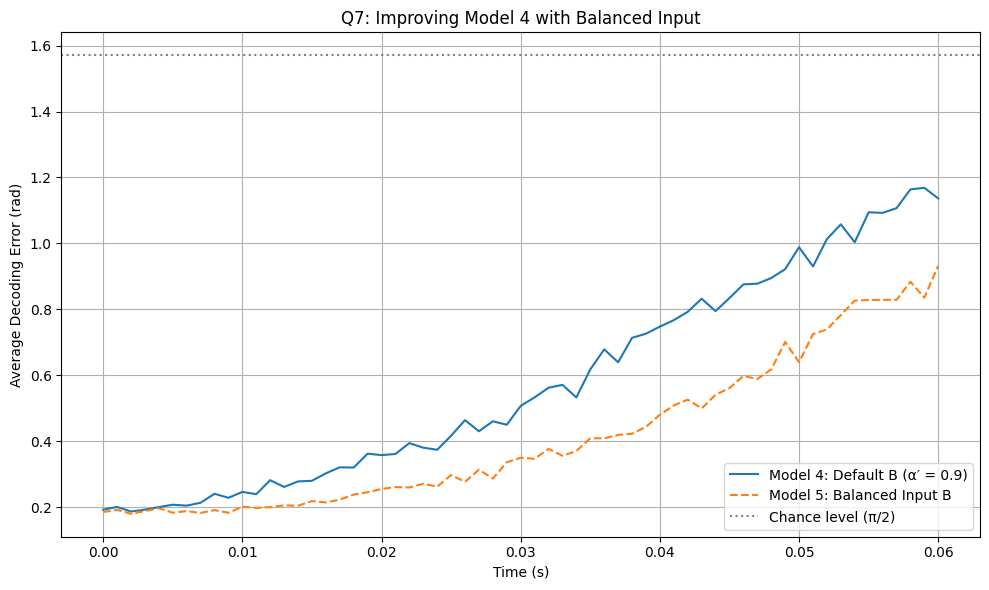

In [13]:
# --- Model 5 Simulation ---
W5, B5, C5, _ = network_model(5, m, phi, alpha, alpha_prime)
r5 = simulate_model(W5, B5, C5, h_theta, tau, dt, num_time_steps)
error5 = compute_decoding_error(r5, C5, sigma, phi, theta, num_trials=500)

# --- Plot Model 4 vs Model 5 ---
plt.figure(figsize=(10, 6))
plt.plot(time_axis, error4, label='Model 4: Default B (α′ = 0.9)')
plt.plot(time_axis, error5, label='Model 5: Balanced Input B', linestyle='--')
plt.axhline(np.pi / 2, color='gray', linestyle=':', label='Chance level (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Q7: Improving Model 4 with Balanced Input")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 8

In [43]:
# --- Setup ---
alpha_primes = [0.5, 1, 2, 3, 5, 10, 25, 50]
decoding_errors = []
spectral_radii = []
norms_at_t60 = []
variances_at_t60 = []
heatmaps_at_t60 = []

# --- Simulation parameters ---
h_theta = h_theta_vector(phi, theta)

for alpha_prime in alpha_primes:
    W, B, C, _ = network_model(4, m, phi, alpha=0.9, alpha_prime=alpha_prime)
    r = simulate_model(W, B, C, h_theta, tau, dt, num_time_steps)

    # Decode error
    err = compute_decoding_error(r, C, sigma, phi, theta, num_trials=100)
    decoding_errors.append(err)

    # Spectral radius
    eigvals = np.linalg.eigvals(W)
    spectral_radii.append(np.max(np.abs(eigvals)))

    # Final timestep stats
    final_r = r[:m, -1]  # only excitatory population
    norms_at_t60.append(np.linalg.norm(final_r))
    variances_at_t60.append(np.var(final_r))
    heatmaps_at_t60.append(final_r)


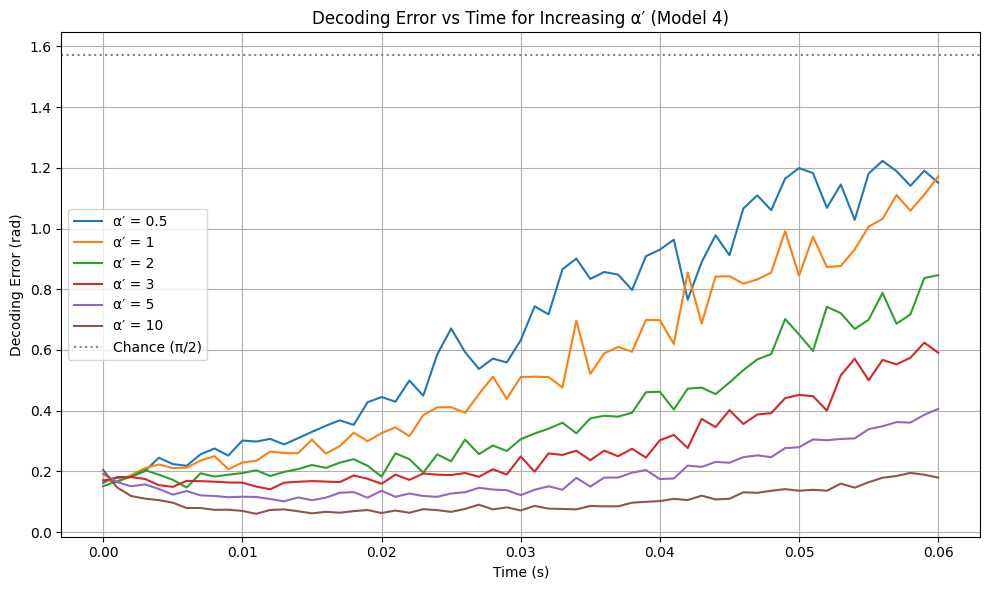

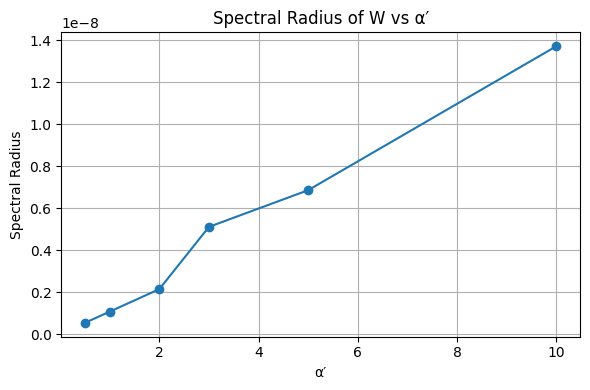

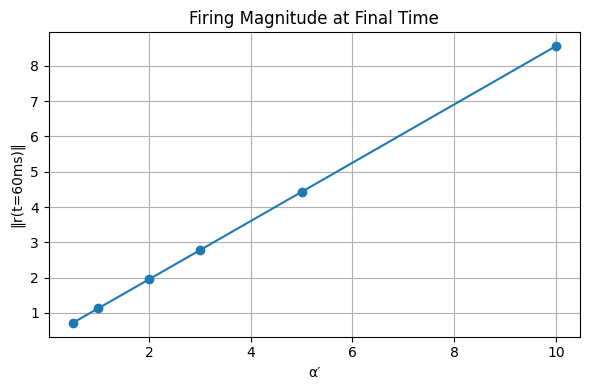

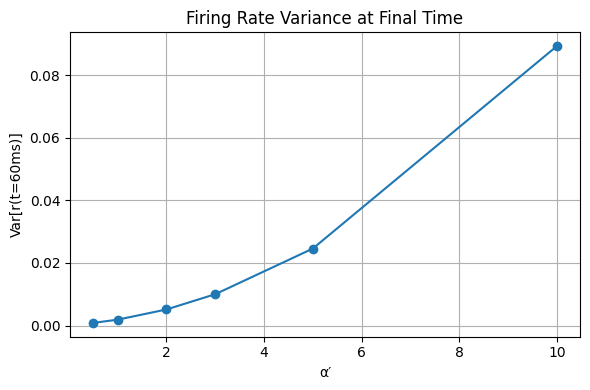

/var/folders/8m/mlfdjz4d5bd1hd67c6nkhb_00000gn/T/ipykernel_9022/2917631432.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


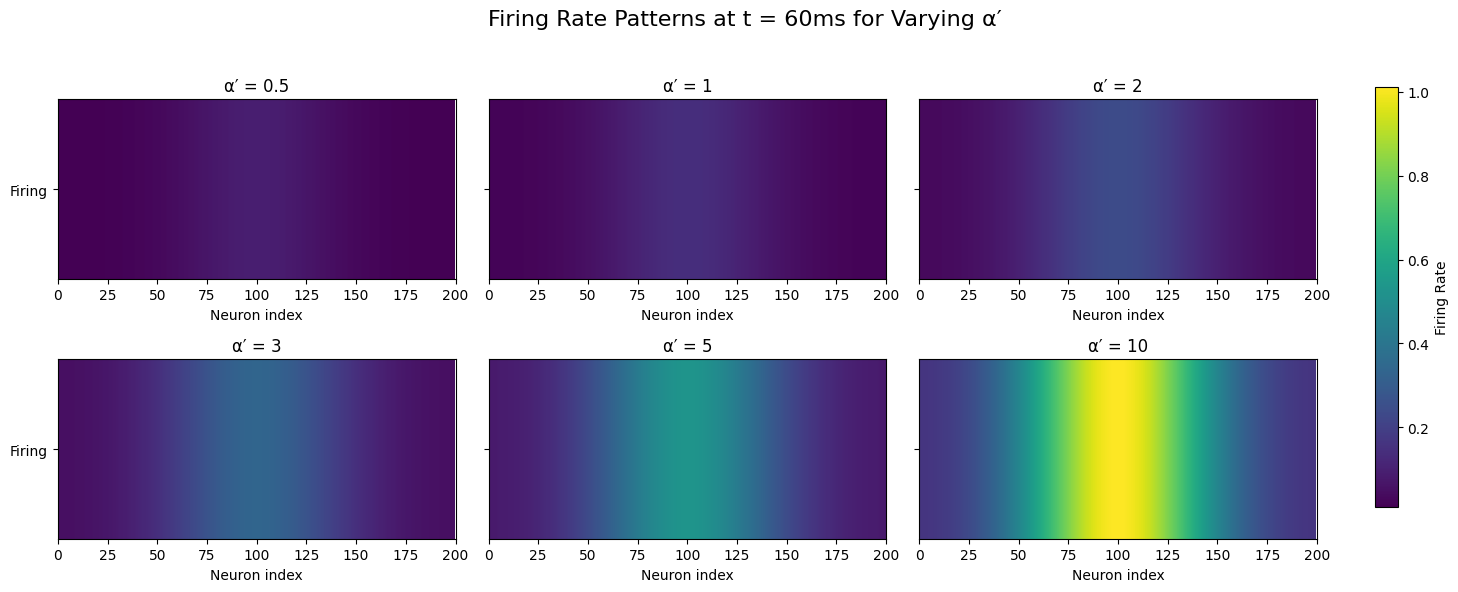

In [17]:
# 1. Decoding error over time
plt.figure(figsize=(10, 6))
for i, a in enumerate(alpha_primes):
    plt.plot(time_axis, decoding_errors[i], label=f"α′ = {a}")
plt.axhline(np.pi/2, linestyle=':', color='gray', label='Chance (π/2)')
plt.xlabel("Time (s)")
plt.ylabel("Decoding Error (rad)")
plt.title("Decoding Error vs Time for Increasing α′ (Model 4)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Spectral radius
plt.figure(figsize=(6, 4))
plt.plot(alpha_primes, spectral_radii, marker='o')
plt.xlabel("α′")
plt.ylabel("Spectral Radius")
plt.title("Spectral Radius of W vs α′")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Firing norm at t = 60ms
plt.figure(figsize=(6, 4))
plt.plot(alpha_primes, norms_at_t60, marker='o')
plt.xlabel("α′")
plt.ylabel("‖r(t=60ms)‖")
plt.title("Firing Magnitude at Final Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Variance of firing rates at t = 60ms
plt.figure(figsize=(6, 4))
plt.plot(alpha_primes, variances_at_t60, marker='o')
plt.xlabel("α′")
plt.ylabel("Var[r(t=60ms)]")
plt.title("Firing Rate Variance at Final Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Heatmaps of firing activity at t = 60ms (with axis labels and colorbar)
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharey=True)
axs = axs.flatten()

# Use a common vmin/vmax for consistent color scaling
vmin = min([np.min(h) for h in heatmaps_at_t60])
vmax = max([np.max(h) for h in heatmaps_at_t60])

for i, a in enumerate(alpha_primes):
    im = axs[i].imshow(heatmaps_at_t60[i][np.newaxis, :], aspect='auto',
                       cmap='viridis', vmin=vmin, vmax=vmax)
    axs[i].set_title(f"α′ = {a}")
    axs[i].set_yticks([0])
    axs[i].set_yticklabels(["Firing"])
    axs[i].set_xlabel("Neuron index")
    axs[i].set_xlim(0, m)

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Firing Rate")

fig.suptitle("Firing Rate Patterns at t = 60ms for Varying α′", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()



In [24]:
# --- Extended Time Parameters ---
duration_long = 1.0  # 1000 ms
num_time_steps_long = int(duration_long / dt) + 1
time_axis_long = np.linspace(0, duration_long, num_time_steps_long)

# --- New simulate_model for long duration (non-destructive) ---
def simulate_model_long(W, B, C, h_theta, tau, dt, num_time_steps=num_time_steps_long):
    n_model = W.shape[0]
    r = np.zeros((n_model, num_time_steps))
    r[:, 0] = B @ h_theta
    for i in range(1, num_time_steps):
        dr = (-r[:, i-1] + W @ r[:, i-1]) * (dt / tau)
        r[:, i] = r[:, i-1] + dr
    return r

# --- New compute_decoding_error for long duration (non-destructive) ---
def compute_decoding_error_long(r, C, sigma, phi, theta, num_trials=100):
    m, T = C.shape[0], r.shape[1]
    all_errors = []
    for _ in range(num_trials):
        trial_errors = []
        for t in range(T):
            noise = sigma * np.random.randn(m)
            o_tilde = C @ r[:, t] + noise
            x = np.sum(o_tilde * np.cos(phi))
            y = np.sum(o_tilde * np.sin(phi))
            theta_hat = np.arctan2(y, x) % (2 * np.pi)
            error = np.abs(np.angle(np.exp(1j * (theta_hat - theta))))
            trial_errors.append(error)
        all_errors.append(trial_errors)
    return np.mean(all_errors, axis=0)


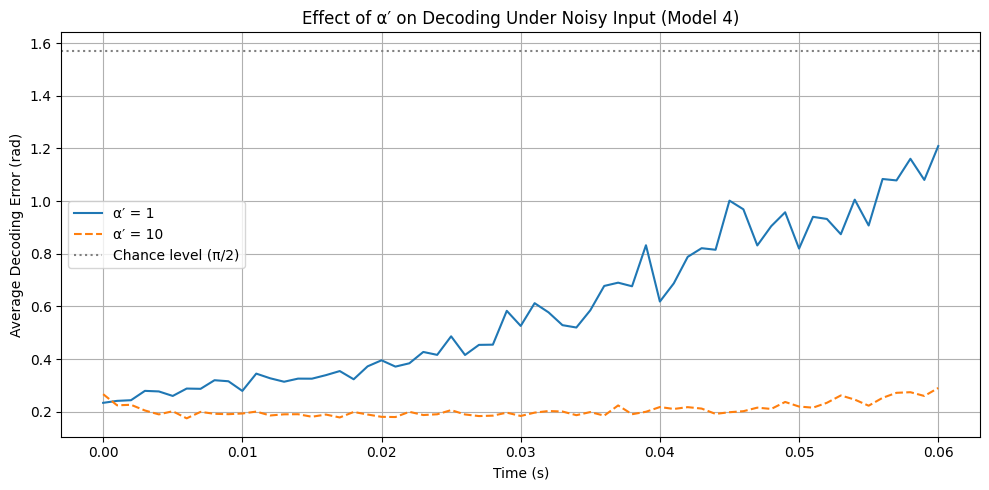

In [25]:
# --- Q8 Plot 4: Response to Weak/Noisy Stimulus ---

alpha_prime_low = 1
alpha_prime_high = 10
noise_strength = 1
num_trials = 100

# Use a noisy version of the stimulus
def noisy_h_theta(phi, theta, noise_scale=noise_strength):
    return h_theta_vector(phi, theta) + noise_scale * np.random.randn(len(phi))

# Run Model 4 with noisy input for both α′ values
errors_low = []
errors_high = []

for _ in range(num_trials):
    h_noisy = noisy_h_theta(phi, theta)

    # α′ = 1
    W_low, B_low, C_low, _ = network_model(4, m, phi, alpha=0.9, alpha_prime=alpha_prime_low)
    r_low = simulate_model(W_low, B_low, C_low, h_noisy, tau, dt, num_time_steps_long)
    err_low = compute_decoding_error(r_low, C_low, sigma, phi, theta, num_trials=1)
    errors_low.append(err_low)

    # α′ = 10
    W_high, B_high, C_high, _ = network_model(4, m, phi, alpha=0.9, alpha_prime=alpha_prime_high)
    r_high = simulate_model(W_high, B_high, C_high, h_noisy, tau, dt, num_time_steps_long)
    err_high = compute_decoding_error(r_high, C_high, sigma, phi, theta, num_trials=1)
    errors_high.append(err_high)

# Average decoding errors across trials
avg_error_low = np.mean(errors_low, axis=0)
avg_error_high = np.mean(errors_high, axis=0)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time_axis, avg_error_low, label="α′ = 1")
plt.plot(time_axis, avg_error_high, label="α′ = 10", linestyle="--")
plt.axhline(np.pi / 2, color="gray", linestyle=":", label="Chance level (π/2)")
plt.xlabel("Time (s)")
plt.ylabel("Average Decoding Error (rad)")
plt.title("Effect of α′ on Decoding Under Noisy Input (Model 4)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


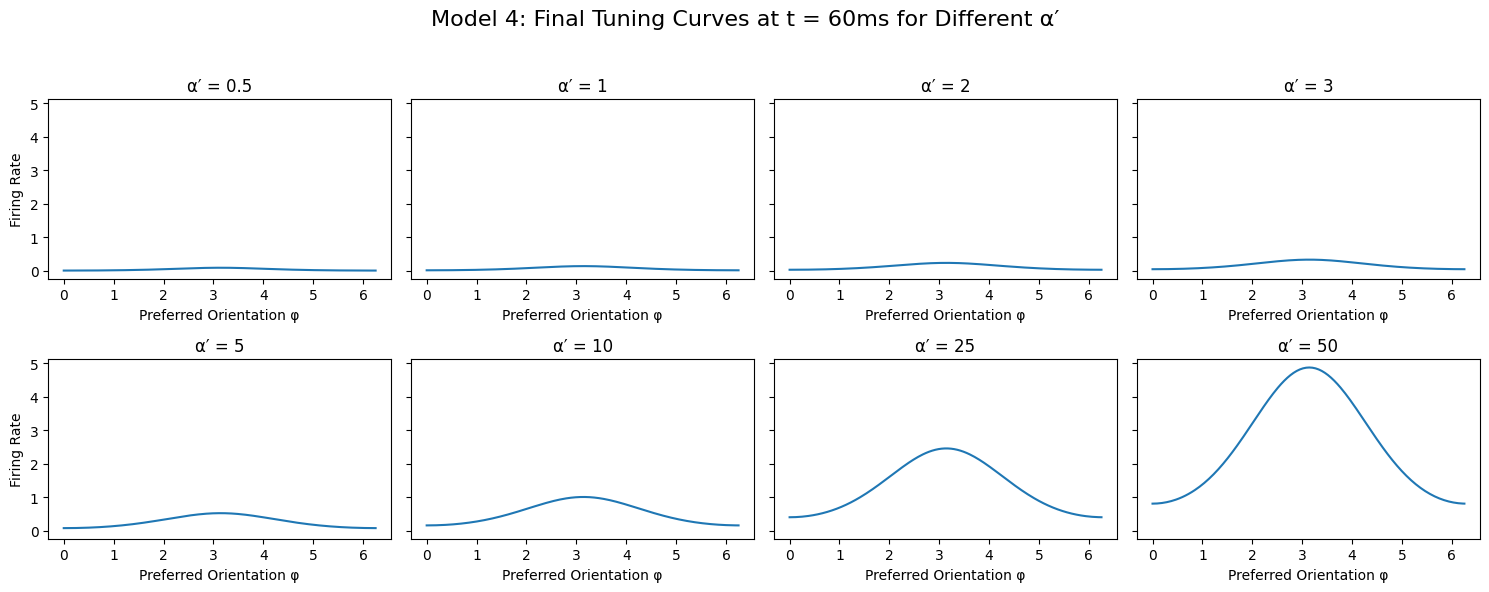

In [44]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True)
axs = axs.flatten()

for i, a in enumerate(alpha_primes):
    r_final = heatmaps_at_t60[i]
    axs[i].plot(phi, r_final)
    axs[i].set_title(f"α′ = {a}")
    axs[i].set_xlabel("Preferred Orientation φ")
    if i % 4 == 0:
        axs[i].set_ylabel("Firing Rate")

fig.suptitle("Model 4: Final Tuning Curves at t = 60ms for Different α′", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
